In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
(X, _), (_, _) = mnist.load_data()
X = X / 127.5 - 1.
X = np.expand_dims(X, axis=3)
X.shape


11493376/11490434 [==============================] - 1s 0us/step


(60000, 28, 28, 1)


Note that we've added another dimension for the channel which is usually for the color value (red, green, blue). Since these images are greyscale it's not strictly necessary but Keras expects an input array in this shape.

The first thing we need to do is define the generator. This is the model that will learn how to produce new images. The architecture looks a lot like a normal convolutional network except in reverse. We start with an input that is essentially random noise and mold it into an image through a series of convolution blocks. All of these layers should be familiar to anyone that's worked with convolutional networks before with the possible exception of the "upsampling" layer, which essentially doubles the size of the tensor along two axes by repeating rows and columns.

In [0]:
from keras.models import Model
from keras.layers import Activation, BatchNormalization, Conv2D
from keras.layers import Dense, Input, Reshape, UpSampling2D

def get_generator(noise_shape):
    i = Input(noise_shape)

    x = Dense(128 * 7 * 7)(i)
    x = Activation("relu")(x)
    x = Reshape((7, 7, 128))(x)
    x = UpSampling2D()(x)

    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)
    x = UpSampling2D()(x)

    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)

    x = Conv2D(1, kernel_size=3, padding="same")(x)
    o = Activation("tanh")(x)
    
    return Model(i, o)

In [5]:
#The below model summary will help us better understand the output and track changes in shape.

g = get_generator(noise_shape=(100,))
g.summary()

W0724 04:23:57.196420 140374738642816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 04:23:57.241134 140374738642816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 04:23:57.249500 140374738642816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 04:23:57.284086 140374738642816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0724 04:23

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
activation_1 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
__________

Building Descriminator: This model will be tasked with looking at an image and deciding if it's really an MNIST image or if it's a fake. The discriminator looks a lot more like a standard convolutional network. It takes a tensor of an image as it's input and runs it through a series of convolution blocks, decreasing in size until it outputs a single activation representing the probability of the tensor being a real MNIST image.

In [0]:
from keras.layers import Dropout, Flatten, LeakyReLU, ZeroPadding2D

def get_discriminator(img_shape):
    i = Input(img_shape)
    
    x = Conv2D(32, kernel_size=3, strides=2, padding="same")(i)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(i)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    o = Dense(1)(x)
    o = Activation("sigmoid")(o)
    
    return Model(i, o)

In [7]:
d = get_discriminator(img_shape=(28, 28, 1))
d.summary()

W0724 04:24:06.452110 140374738642816 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         73856     
__________

The classic idea behing GAN is to set two models into battle against one another and let them develop themselves. Practically thought we focus on obtaining a single model as our end product and in here we will procure the optimum weight values of the GENERATOR hence before we define the generator and feed its o/p to Descriminator we will first compile descriminator so as to prevent changes in it's weights. Finally, a third model is created combining the original input to the generator and the output of the discriminator.

In [0]:
from keras.optimizers import Adam

def DCGAN():
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    discriminator = get_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    generator = get_generator(noise_shape=(100,))
    z = Input(shape=(100,))
    g_out = generator(z)
    discriminator.trainable = False
    d_out = discriminator(g_out)
    combined = Model(z, d_out)
    combined.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return generator, discriminator, combined

In [10]:
generator, discriminator, combined = DCGAN()
combined.summary()

W0724 04:24:23.921836 140374738642816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 04:24:23.934233 140374738642816 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_4 (Model)              (None, 28, 28, 1)         856193    
_________________________________________________________________
model_3 (Model)              (None, 1)                 387841    
Total params: 1,244,034
Trainable params: 855,809
Non-trainable params: 388,225
_________________________________________________________________




```
Create a function to save the generator's output so we can visually see the results. We'll use this in the training loop below.


```



In [0]:
def save_image(generator, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_images = generator.predict(noise)
    gen_images = 0.5 * gen_images + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap="gray")
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("mnist_%d.png" % (batch))
    plt.close()


The last challenge with building a GAN is training the whole thing. With something this complex we can't just call the standard fit function because there are multiple steps involed. Let's roll our own and see how the algorithm works. S**tart by generating some random noise and feeding it through the generator to produce a batch of "fake" images. Next, select a batch of real images from the training data. Now train the distriminator on both the fake image batch and the real image batch, setting labels appropriately (0 for fake and 1 for real). Finally, train the generator by feeding the "combined" model a batch of noise with the "real" label.**

You may find this last step confusing. Remember what this "combined" model is doing. It runs the input (random noise) through the generator, then runs that output through the discriminator (which is frozen), and gets a loss. What this ends of doing in essence is saying "train the generator to minimize the discriminator's ability to discern this output from a real image". This has the effect, over time, of causing the generator to produce realistic images!

In [0]:
def train(generator, discriminator, combined, X, batch_size, n_batches):
    t0 = time.time()
    for batch in range(n_batches + 1):
        t1 = time.time()
        noise = np.random.normal(0, 1, (batch_size, 100))
        
        # Create fake images
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))

        # Select real images
        idx = np.random.randint(0, X.shape[0], batch_size)
        real_images = X[idx]
        real_labels = np.ones((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = combined.train_on_batch(noise, real_labels)
        t2 = time.time()

        # Report progress
        if batch % 100 == 0:
            print("Batch %d/%d [Batch time: %.2f s, Total: %.2f m] [D loss: %f, Acc: %.2f%%] [G loss: %f]" %
                  (batch, (n_batches), (t2 - t1), ((t2 - t0) / 60), d_loss[0], 100 * d_loss[1], g_loss))
        if batch % 500 == 0:
            save_image(generator, batch)

In [13]:
#Run training loop for additional time. This will take some time on free machines like this notebook.
train(generator, discriminator, combined, X=X, batch_size=32, n_batches=3000)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Batch 0/3000 [Batch time: 5.55 s, Total: 0.09 m] [D loss: 1.146077, Acc: 25.00%] [G loss: 0.691406]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Batch 100/3000 [Batch time: 1.15 s, Total: 2.01 m] [D loss: 0.724045, Acc: 62.50%] [G loss: 1.280417]
Batch 200/3000 [Batch time: 1.13 s, Total: 3.93 m] [D loss: 1.052993, Acc: 32.81%] [G loss: 1.365241]
Batch 300/3000 [Batch time: 1.14 s, Total: 5.83 m] [D loss: 0.796356, Acc: 56.25%] [G loss: 1.479431]
Batch 400/3000 [Batch time: 1.14 s, Total: 7.74 m] [D loss: 0.846784, Acc: 42.19%] [G loss: 1.172733]
Batch 500/3000 [Batch time: 1.14 s, Total: 9.66 m] [D loss: 0.868314, Acc: 46.88%] [G loss: 1.427215]
Batch 600/3000 [Batch time: 1.14 s, Total: 11.59 m] [D loss: 0.760511, Acc: 50.00%] [G loss: 1.151410]
Batch 700/3000 [Batch time: 1.15 s, Total: 13.52 m] [D loss: 0.639073, Acc: 64.06%] [G loss: 1.107567]
Batch 800/3000 [Batch time: 1.14 s, Total: 15.44 m] [D loss: 0.776534, Acc: 51.56%] [G loss: 1.212320]
Batch 900/3000 [Batch time: 1.16 s, Total: 17.36 m] [D loss: 0.789504, Acc: 45.31%] [G loss: 1.283390]
Batch 1000/3000 [Batch time: 1.15 s, Total: 19.27 m] [D loss: 0.822783, Acc: 4

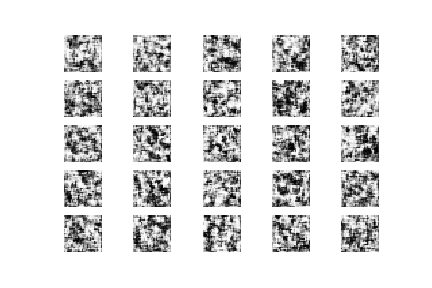

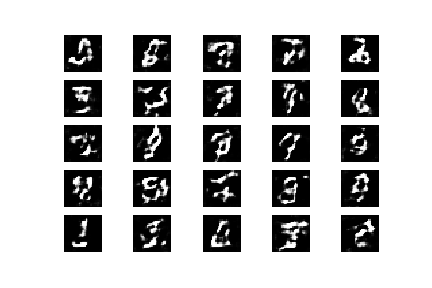

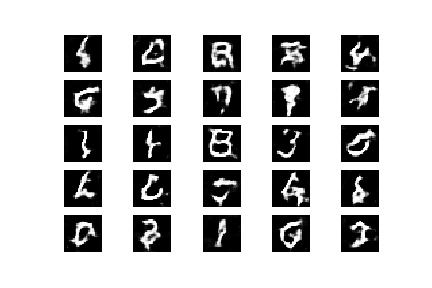

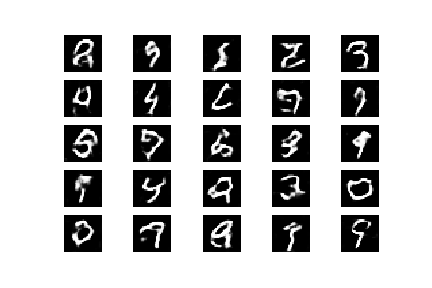

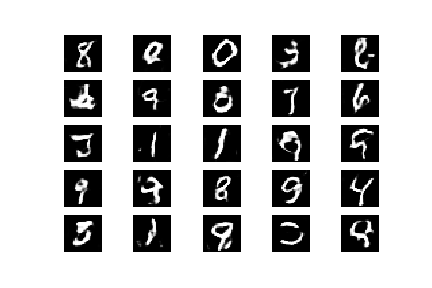

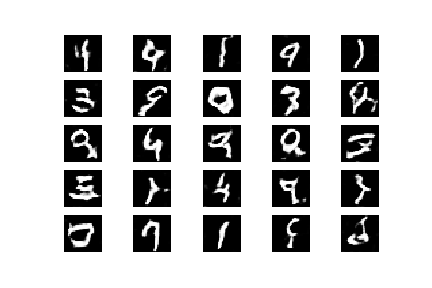

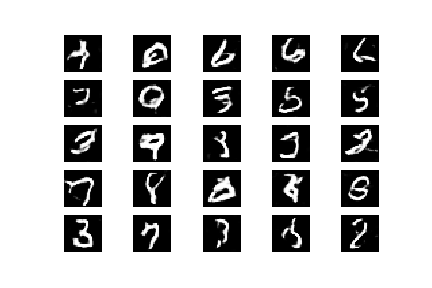

In [14]:
from IPython.display import Image, display

names = ["mnist_0.png",
         "mnist_500.png",
         "mnist_1000.png",
         "mnist_1500.png",
         "mnist_2000.png",
         "mnist_2500.png",
         "mnist_3000.png"]

for name in names:
    display(Image(filename=name))